In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy
from matplotlib.backends.backend_agg import FigureCanvasAgg
from dataset import Dataset
from IPython import display
from proc import *

In [2]:
MAX_ITER = 20

# 參數設定

## 輸入

- 正常
    - `dataset/bag/`
    - `dataset/bmx/`
    - `dataset/bolt2/`
    
- 遮蔽後變換目標
    - `dataset/fernando/`

In [3]:
data = Dataset('dataset/bmx/')

## 輸出

In [4]:
OUTPUT_FILENAME = 'tmp_out.avi'

# 執行

## 初始化

initial target


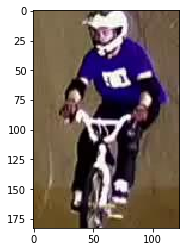

whole image


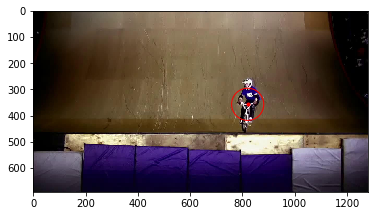


figure size
[432 288]

frame count
76


In [5]:
q0 = create_target_model(data.target(0))
y0 = numpy.average(data.gtruth[0], 0).astype(int)
h = numpy.min(numpy.diff(data.gtruth[0], axis=0).astype(int))

#
print('initial target')
plt.imshow(cv2.cvtColor(data.target(0), cv2.COLOR_BGR2RGB))
plt.show()

print('whole image')
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(data.imgs[0], cv2.COLOR_BGR2RGB))
ax.add_artist(plt.Circle(y0, h/2, color='r', fill=False))
ax.plot(*y0, 'r.')
plt.show()

fig_size = (fig.get_size_inches()*fig.dpi).astype(int)
print(f'\nfigure size\n{fig_size}')

frame_cnt = len(data)
print(f'\nframe count\n{frame_cnt}')

## 準備儲存

In [6]:
out_video = cv2.VideoWriter(
    filename=OUTPUT_FILENAME,
    fourcc=cv2.VideoWriter_fourcc(*'MJPG'),
    fps=15,
    frameSize=tuple(fig_size),
    isColor=True
)

canvas = FigureCanvasAgg(fig)

## 計算

In [7]:
for i, img in enumerate(data.imgs[1:]):
    p_y0 = create_target_candidate(img, y0, h)

    rho0 = numpy.sum(numpy.sqrt(p_y0 * q0))
    D = calc_weight(img, q0, p_y0, y0, h)

    x, y = meanshift(D)
    y1 = numpy.array((x, y)) + y0

    p_y1 = create_target_candidate(img, y1, h)
    rho1 = numpy.sum(numpy.sqrt(p_y1 * q0))
    
    itr = 0
    while rho1 < rho0 and itr < MAX_ITER:
        y1 = (y0 + y1) /2
        p_y1 = create_target_candidate(data.imgs[1], y1, h)
        rho1 = numpy.sum(numpy.sqrt(p_y1 * q0))
        itr += 1

    y0 = y1
    q0 = p_y1
    
    # output
    print(f'#{i}/{frame_cnt}: shift ({x}, {y})'+' '*20, end='\r')
    
    ax.clear()
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.add_artist(plt.Circle(y1, h/2, color='r', fill=False))
    ax.plot(*y1, 'r.')
    
    canvas.draw()
    
    out_frame = numpy.fromstring(
        canvas.tostring_rgb(), 
        dtype='uint8'
    ).reshape(*fig_size[::-1], 3)
    
    out_frame = cv2.cvtColor(out_frame, cv2.COLOR_RGB2BGR)
    
    out_video.write(out_frame)

out_video.release()
print('- DONE -'+' '*20)

- DONE -                                   


# 輸出

In [8]:
display.Video(OUTPUT_FILENAME)